## __supervision__

- 物体検出やセグメンテーションの可視化ツール

- MMDetectionやYOLOv8、Transformerなどさまざまな推論モデルに対応している

- [Document](https://supervision.roboflow.com/latest/)

### __準備__

In [1]:
!pip install ultralytics supervision | tail -n1

In [2]:
# 画像の準備
!wget https://ultralytics.com/images/bus.jpg
image_path = "bus.jpg"

--2024-06-13 23:28:40--  https://ultralytics.com/images/bus.jpg
Resolving ultralytics.com (ultralytics.com)... 99.83.190.102, 75.2.70.75
Connecting to ultralytics.com (ultralytics.com)|99.83.190.102|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/images/bus.jpg [following]
--2024-06-13 23:28:40--  https://www.ultralytics.com/images/bus.jpg
Resolving www.ultralytics.com (www.ultralytics.com)... 104.18.1.125, 104.18.0.125, 2606:4700::6812:7d, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|104.18.1.125|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg [following]
--2024-06-13 23:28:40--  https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
C

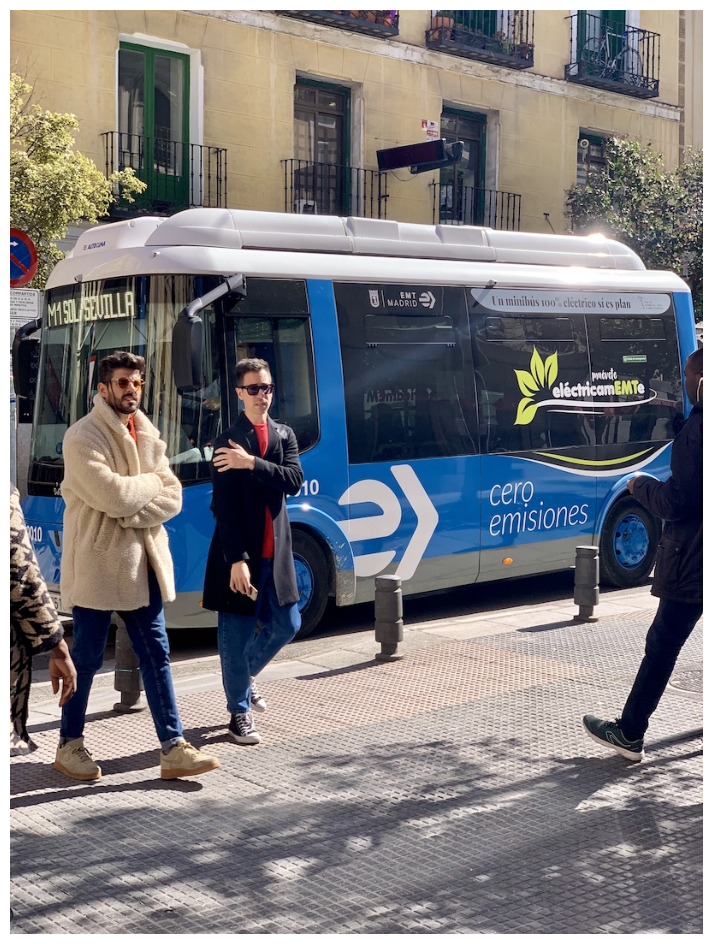

In [3]:
import matplotlib.pyplot as plt
import cv2

def show_image(image_path):
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
show_image(image)

### __物体検出__

100%|██████████| 6.23M/6.23M [00:00<00:00, 62.1MB/s]



0: 640x480 4 persons, 1 bus, 361.9ms
Speed: 15.1ms preprocess, 361.9ms inference, 34.4ms postprocess per image at shape (1, 3, 640, 480)


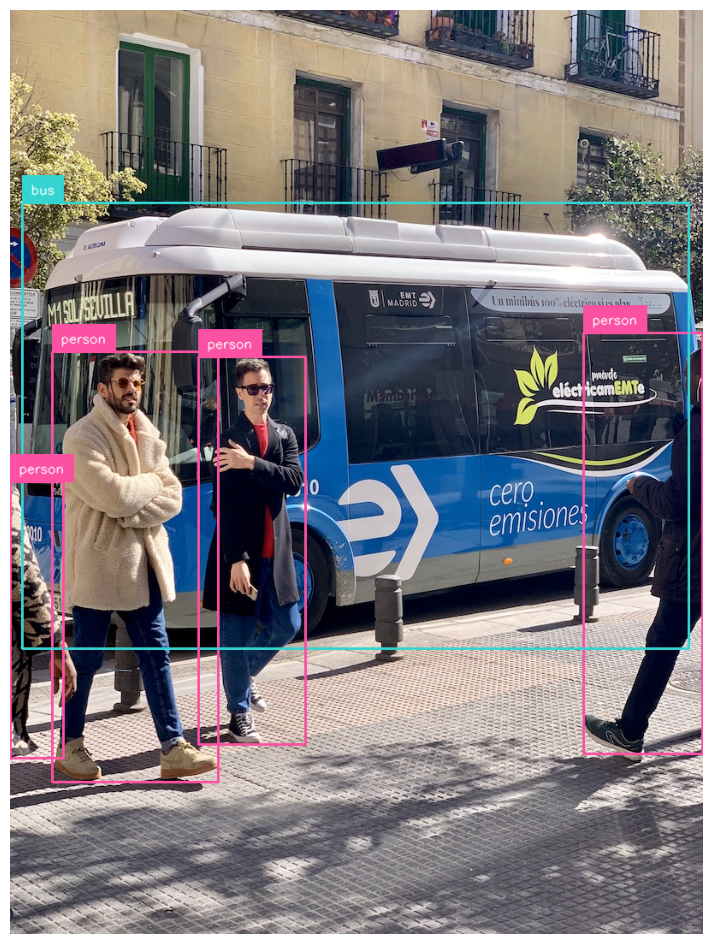

In [4]:
from ultralytics import YOLO
import supervision as sv

# 画像
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# 推論
model = YOLO("yolov8n.pt")
results = model(image)[0]

# supervision用のフォーマットに変換
detections = sv.Detections.from_ultralytics(results)

# 推論結果の画像作成
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# 画像の表示
show_image(annotated_image)

### __インスタンスセグメンテーション__

does not working now

100%|██████████| 6.73M/6.73M [00:00<00:00, 77.6MB/s]



0: 640x480 4 persons, 1 bus, 1 skateboard, 456.5ms
Speed: 4.6ms preprocess, 456.5ms inference, 34.5ms postprocess per image at shape (1, 3, 640, 480)


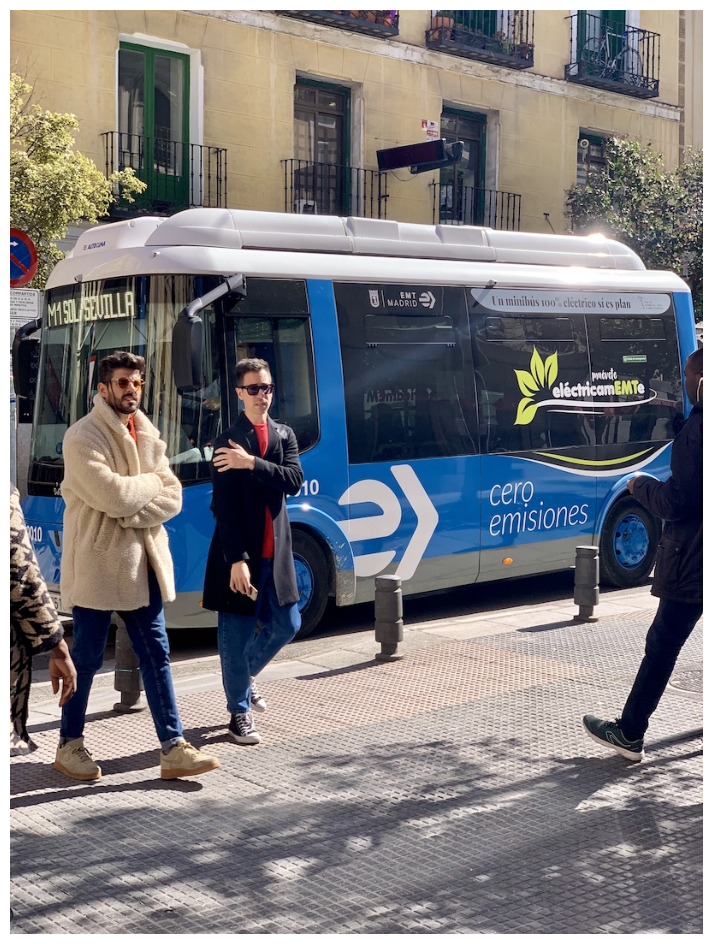

In [5]:
from ultralytics import YOLO
import supervision as sv

# 画像
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# 推論
model = YOLO("yolov8n-seg.pt")
results = model(image)[0]

# supervision用のフォーマットに変換
detections = sv.Detections.from_ultralytics(results)

# 推論結果の画像作成
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = mask_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# 画像の表示
show_image(annotated_image)

### __物体追跡__

1. 各フレームごとに物体検出モデルを適用する

2. ByteTrackという複数物体追跡のアルゴリズムを用いて、IDの対応付けを行う

In [6]:
# 動画のダウンロード
from supervision.assets import download_assets, VideoAssets

download_assets(VideoAssets.PEOPLE_WALKING)

  0%|          | 0/7606633 [00:00<?, ?it/s]

'people-walking.mp4'

In [7]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

# ByteTrackアルゴリズム
tracker = sv.ByteTrack()

# annotators
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# 各フレームに適用する関数
def callback(frame, _):
    # 推論
    results = model(frame)[0]

    # supervision用のフォーマットに変換
    detections = sv.Detections.from_ultralytics(results)

    # ByteTrackを適用
    detections = tracker.update_with_detections(detections)

    labels = [f"#{tracker_id} {results.names[class_id]}" for class_id, tracker_id in zip(detections.class_id, detections.tracker_id)]

    # アノテーションを付与
    annotated_frame = box_annotator.annotate(frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=labels)
    annotated_frame = trace_annotator.annotate(annotated_frame, detections=detections)
    return annotated_frame

# 推論
sv.process_video(
    source_path="people-walking.mp4", # 入力
    target_path="result.mp4", # 出力
    callback=callback,
)


0: 384x640 37 persons, 2 birds, 243.7ms
Speed: 4.6ms preprocess, 243.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 3 birds, 234.1ms
Speed: 5.5ms preprocess, 234.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 3 birds, 242.9ms
Speed: 4.3ms preprocess, 242.9ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 3 birds, 251.5ms
Speed: 6.2ms preprocess, 251.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 2 birds, 222.7ms
Speed: 3.6ms preprocess, 222.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 2 birds, 261.1ms
Speed: 4.3ms preprocess, 261.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 224.8ms
Speed: 12.2ms preprocess, 224.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 

### __SAM__

In [8]:
# SAMのGithubリポジトリ
!pip install -q git+https://github.com/facebookresearch/segment-anything.git | tail -n1

# モデルのダウンロード
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# モデル
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
import cv2
import supervision as sv

# 画像
image = cv2.imread(image_path)

# 推論
results = mask_generator.generate(image)

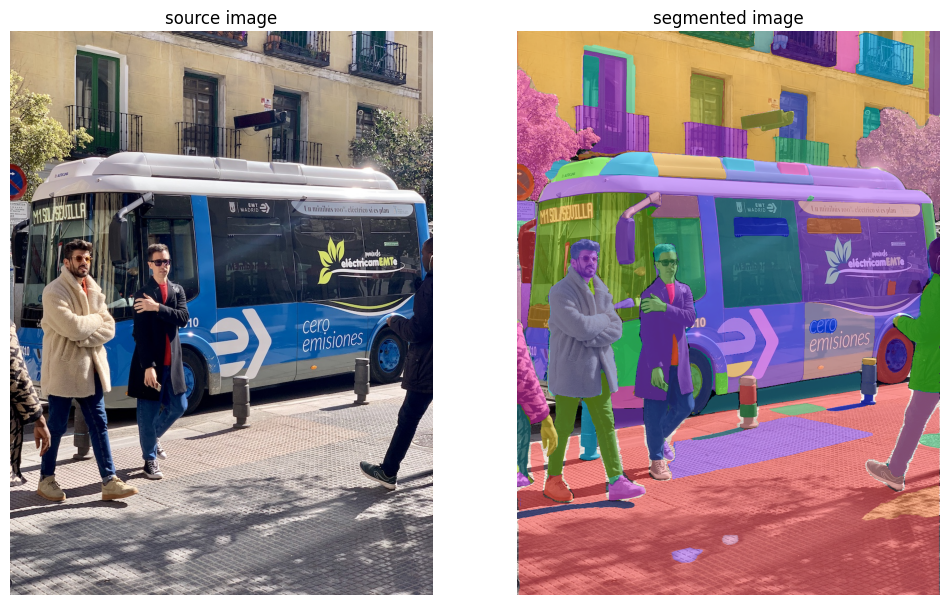

In [13]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# supervision用のフォーマットに変換
detections = sv.Detections.from_sam(results)

# アノテーションを付与
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

# 2つの画像を表示
sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'],
)